## Notebook for using DenseNet to tell if the MCA is visible for a slice
Pipeline:
- Import data
- Find volume with the highest cumulative intensity for each patient
- Discard all other volumes
- Perform train, val, test split
- Normalize data
- Initialize model
- Train model
- Test model
- Visualize results
- Use KMeans to extract AIFs

In [1]:
# Imports
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import createImageIndexCSV, get_max_intensity_for_dataset
from torch import nn
import os
import json
# Dataleakage from Kmeans
os.environ["OMP_NUM_THREADS"] = "1"

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 128
EPOCHS = 50
# image_path = "D:/AIF_DCE"
image_path = "D:/iCAT_IMAGES/"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [2]:
# Import original dataset
image_data = createImageIndexCSV(image_path, force=False,
                                 result_file_path='./data_indexes/series_data_indices.csv')
mca_labels = pd.read_excel('./data_indexes/MCA_labels.xlsx')


In [3]:
# Remove unused patients from sailor to reduce preprocessing time
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index)
image_data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]


In [4]:
intensities = get_max_intensity_for_dataset(
    image_data, './data_indexes/volume_intensities.csv')


In [5]:
# # Change the label dataframe to be compatible with efficient datahandling
# mca_labels = pd.melt(mca_labels, id_vars=[
#                      'Patient', 'Series'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Series', 'Slice'])
# mca_labels_sailor = pd.melt(mca_labels_sailor, id_vars=[
#     'Patient', 'Series'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Series', 'Slice'])

# train_images, val_images, test_images, train_labels, val_labels, test_labels = load_and_prepare_images_from_txt(
#     {"train" : "./data_indexes/train_patients.txt", "val" : "./data_indexes/val_patients.txt", "test" : "./data_indexes/test_patients.txt"},
#     image_data, mca_labels, intensities, SEED=SEED, extra_vols=5)

# train_images_sailor, val_images_sailor, test_images_sailor, train_labels_sailor, val_labels_sailor, test_labels_sailor = load_and_prepare_images_from_txt(
#     {"train" : "./data_indexes/train_patients_sailor.txt", "val" : "./data_indexes/val_patients_sailor.txt", "test" : "./data_indexes/test_patients_sailor.txt"},
#     image_data_sailor, mca_labels_sailor, intensities_sailor, SEED=SEED, extra_vols=2)


Added data 850. Original amount of data 2592
Size training, val, and test data: 3442, 336, 336.
True labels in training: 1020 of 3442 (29.6%).
True labels in validation: 22 of 336 (6.5%).
True labels in test: 27 of 336 (8.0%).
Added data 178. Original amount of data 352
Size training, val, and test data: 530, 308, 495.
True labels in training: 267 of 530 (50.4%).
True labels in validation: 83 of 308 (26.9%).
True labels in test: 124 of 495 (25.1%).


In [10]:
# combine_datasets(train_images, train_images_sailor, train_labels, train_labels_sailor, "train")
# combine_datasets(val_images, val_images_sailor, val_labels, val_labels_sailor, "val")
# combine_datasets(test_images, test_images_sailor, test_labels, test_labels_sailor, "test")


In [ ]:
# TODO: concat training, val, and test data between sailor and original. Take care of patient numbering.


In [5]:
from utils.datahandling_utils import get_patients_from_txt, sort_imagedata_on_patients

dist = get_patients_from_txt({"train": "./data_indexes/train_patients.txt",
                             "val": "./data_indexes/val_patients.txt", "test": "./data_indexes/test_patients.txt"})
train_images, val_images, test_images = sort_imagedata_on_patients(
    image_data, dist)

train_labels = np.isin(mca_labels['Patient'],
                       np.unique(train_images['Patient']))
train_labels = mca_labels[train_labels]
val_labels = np.isin(mca_labels['Patient'], np.unique(val_images['Patient']))
val_labels = mca_labels[val_labels]
test_labels = np.isin(mca_labels['Patient'], np.unique(test_images['Patient']))
test_labels = mca_labels[test_labels]


In [6]:
with open('./trained_models/best_config.txt', 'r') as f:
    data = f.read()
    best_config = json.loads(data)


In [7]:
from models.dense_net_torch import DenseNet
torch.manual_seed(SEED)
model = DenseNet(growth_rate=best_config['growth_rate'], num_init_features=best_config['init_features'],
                 bn_size=best_config['bn_size'], drop_rate=best_config['drop_rate'], num_classes=1)
print(
    f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_config['lr'])


Total number of trainable parameters 1541315


In [8]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('./trained_models/model_100_2023_5_4.pt'))
model = model.to(device)
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 26, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(26, 60, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(60, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(41, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [9]:
import matplotlib.pyplot as plt
# Fonts similar to latex document
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.style.use('ggplot')


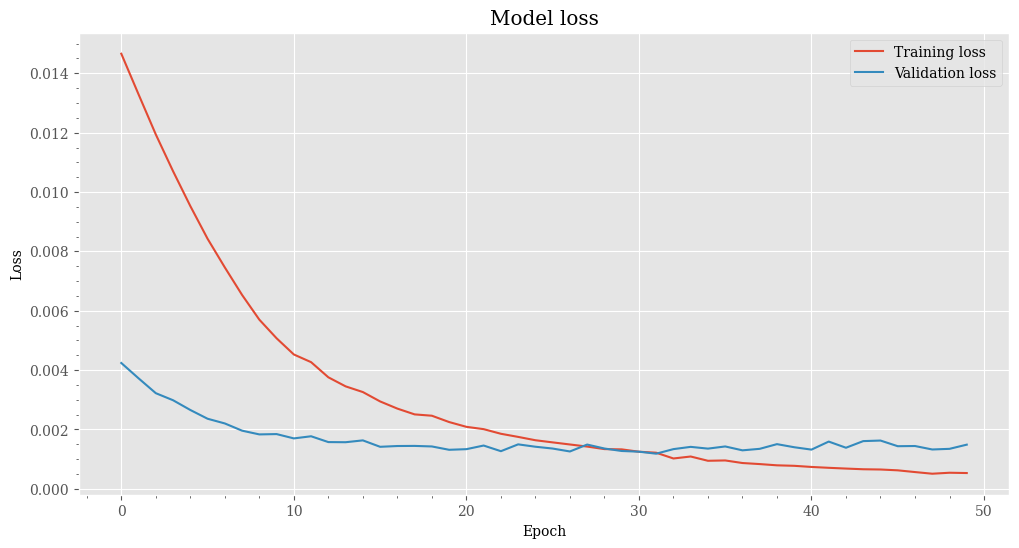

In [19]:
# import matplotlib.pyplot as plt
# # Fonts similar to latex document
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "dejavuserif"
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[0][:, 0], label='Training loss')
# plt.plot(losses[0][:, 1], label='Validation loss')
# plt.xlabel('Epoch')
# plt.minorticks_on()
# plt.ylabel('Loss')
# plt.title('Model loss')
# plt.legend(loc='upper right')


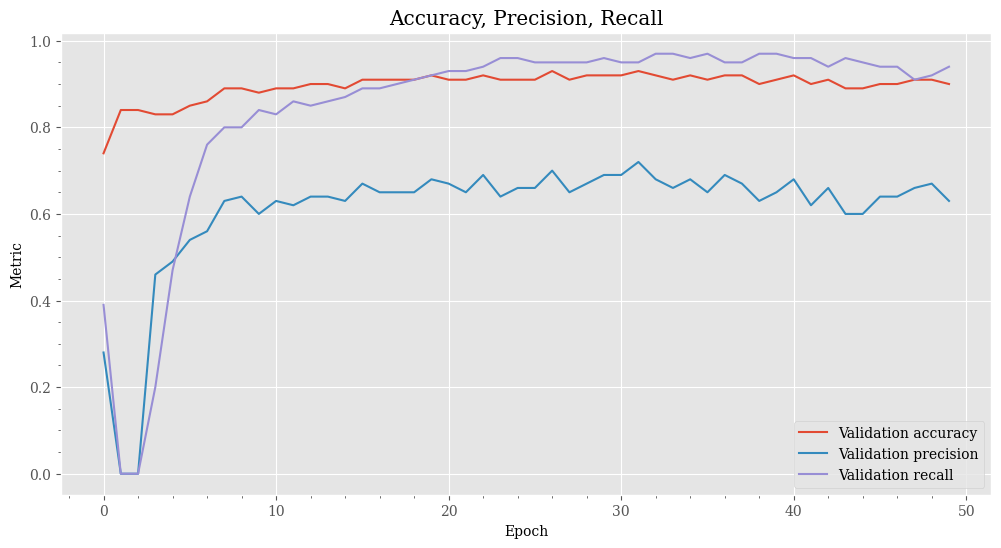

In [20]:
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[1][:, 0], label='Validation accuracy')
# plt.plot(losses[1][:, 1], label='Validation precision')
# plt.plot(losses[1][:, 2], label='Validation recall')
# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.minorticks_on()
# plt.title('Accuracy, Precision, Recall')
# plt.legend(loc='lower right')


In [45]:
from utils.model_utils import get_label_curves, get_pred_curves

actual_curves = get_label_curves(
    image_data, label_path='./data_indexes/AIF_images.xlsx')
pred_curves_sigmoid, pred_info_sigmoid, pred_masks_sigmoid = get_pred_curves(model, image_data, np.unique(
    test_images['Patient']), intensities, device, SEED, crop=0.7, pred_type='sigmoid')
pred_curves_all, pred_info_all, pred_masks_all = get_pred_curves(model, image_data, np.unique(
    test_images['Patient']), intensities, device, SEED, crop=0.7, pred_type='all')
pred_curves_global, pred_info_global, pred_masks_global = get_pred_curves(model, image_data, np.unique(
    test_images['Patient']), intensities, device, SEED, crop=0.7, pred_type='global')


d:\dev\Masterthesis\models\mouridsen_new.py:21: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
d:\dev\Masterthesis\models\mouridsen_new.py:21: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
d:\dev\Masterthesis\models\mouridsen_new.py:21: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
d:\dev\Masterthesis\models\mouridsen_new.py:21: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas


In [19]:
np.unique(test_images['Patient'])


array([15, 29, 48, 53, 59, 67, 69], dtype=int64)

In [108]:
pas = 15
actual = actual_curves[pas]
pred = pred_curves_global[pas][1]
info = pred_info_global[pas][1]


Text(0.5, 1.0, 'Predicted vs. actual AIF')

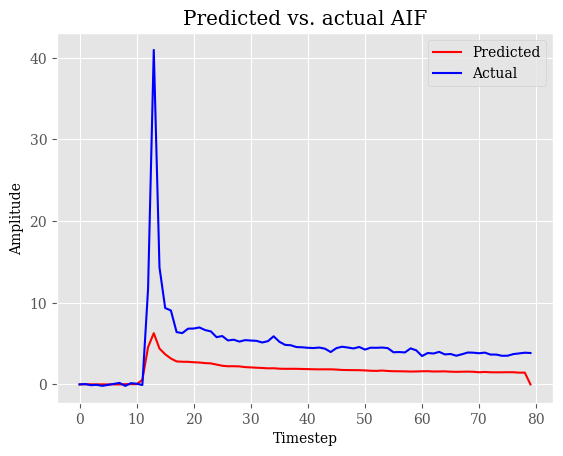

In [109]:
from utils.signal_conversion import SPGR_s2r
fig = plt.figure()
plt.plot(SPGR_s2r(np.average(pred, axis=0),
         info['TR'], info['FA']), color='red', label='Predicted')
plt.plot(actual, color="blue", label="Actual")
plt.legend(loc="upper right")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.title("Predicted vs. actual AIF")


In [82]:
from utils.datahandling_utils import crop_image


def get_image(image_data, intensities, patient, series, slice_idx, crop=0.7):
    volume = intensities[(intensities[:, 0] == patient) &
                         (intensities[:, 1] == series)][0][2]
    image_path = image_data[(image_data['Patient'] == patient) & ((image_data['Series'] == series) & (
        (image_data['Volume'] == volume) & (image_data['Slice'] == slice_idx)))]['ImagePath']
    image = pdc.read_file(image_path.item()).pixel_array
    image = crop_image(image, crop)
    return image


def print_curves_and_coords(p, m, patient, image_data, intensities):
    """
    Accepts p where there are only a single selected slice.
    """
    p = p[patient]
    rows = len(p.keys())
    fig, (a1, a2) = plt.subplots(rows, 2, figsize=(9, 9), sharex='col')
    fig.suptitle(
        f"AIFs and their corresponding locations for patient {patient}")
    for i, series_key in enumerate(list(p.keys())):
        curves = p[series_key]
        curve = np.average(p[series_key], axis=0)
        for c in curves:
            a1.plot(c, alpha=0.2)
        a1.plot(curve, color='red')

        mask = m[patient][series_key][0]
        slices = m[patient][series_key][1]
        if len(slices) > 1:
            slice_idx = np.random.choice(slices)
        else:
            slice_idx = slices[0]
        image = get_image(image_data, intensities,
                          patient, series_key, slice_idx)
        a2.imshow(image, cmap="gray")
        a2.imshow(mask, alpha=0.3, cmap="prism")
        a1.set_title(f"AIF curves in series {series_key} and slice {slices}")
        a1.grid()
        a2.set_title("Voxels in the AIF")
        a2.axis('off')
    # plt.tight_layout()
    plt.show()


In [84]:
np.unique(test_images['Patient'])


array([15, 29, 48, 53, 59, 67, 69], dtype=int64)

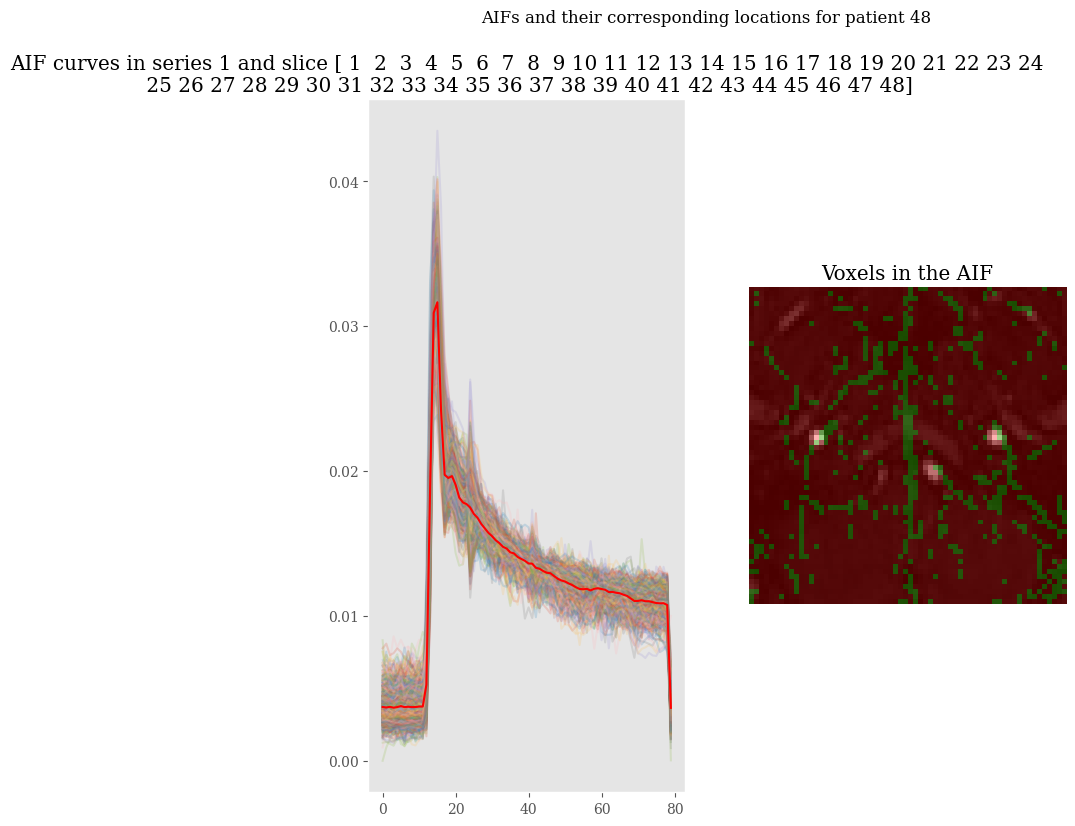

In [95]:
print_curves_and_coords(
    pred_curves_global, pred_masks_global, 48, test_images, intensities)
